In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import optuna.visualization as vis
from sklearn.model_selection import cross_val_score
import time
import joblib

In [68]:
airbnb = pd.read_csv("../data/clean/airbnb_merged.csv")
airbnb

,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,weekend,city
0,194.033698,Private room,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,98.253896,False,Amsterdam
1,344.245776,Private room,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,837.280757,False,Amsterdam
2,264.101422,Private room,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,95.386955,False,Amsterdam
3,433.529398,Private room,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,875.033098,False,Amsterdam
4,485.552926,Private room,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,815.305740,False,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,715.938574,Entire home/apt,6.0,False,0,1,10.0,100.0,3,0.530181,0.135447,219.402478,438.756874,True,Vienna
51703,304.793960,Entire home/apt,2.0,False,0,0,8.0,86.0,1,0.810205,0.100839,204.970121,342.182813,True,Vienna
51704,637.168969,Entire home/apt,2.0,False,0,0,10.0,93.0,1,0.994051,0.202539,169.073402,282.296424,True,Vienna
51705,301.054157,Private room,2.0,False,0,0,10.0,87.0,1,3.044100,0.287435,109.236574,158.563398,True,Vienna


In [66]:
airbnb["bedrooms"].unique()

array([ 1,  2,  3,  0,  5,  4,  6,  9, 10,  8])

# Feature Engineering

In [70]:
numerical_columns = airbnb[[ "cleanliness_rating", "guest_satisfaction_overall", 
                            "dist", "metro_dist", "attr_index", "rest_index"]]

normalizer = MinMaxScaler()
num_norm = normalizer.fit_transform(numerical_columns)

#joblib.dump(ada_reg, "../scalers/normalizer.pkl")

df_norm = pd.DataFrame(num_norm, columns=numerical_columns.columns, index=airbnb.index)
df_norm

,cleanliness_rating,guest_satisfaction_overall,dist,metro_dist,attr_index,rest_index
0,1.000,0.9125,0.198180,0.177775,0.014125,0.011784
1,0.750,0.8125,0.018732,0.016614,0.136943,0.122473
2,0.875,0.8375,0.226885,0.255711,0.013366,0.011355
3,0.875,0.8750,0.014635,0.030661,0.106286,0.128128
4,1.000,0.9750,0.020962,0.022170,0.119526,0.119182
...,...,...,...,...,...,...
51702,1.000,1.0000,0.020386,0.009330,0.045405,0.062784
51703,0.750,0.8250,0.031467,0.006905,0.042197,0.048319
51704,1.000,0.9125,0.038743,0.014031,0.034217,0.039349
51705,1.000,0.8375,0.119870,0.019980,0.020915,0.020817


In [71]:
categorical_nominal = airbnb[["room_type" , "host_is_superhost", "multi", 
                            "biz", "weekend", "city"]]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(categorical_nominal)
#joblib.dump(ada_reg, "../scalers/ohe.pkl")
dummies= ohe.transform(categorical_nominal)

dummies_df = pd.DataFrame(dummies, columns=ohe.get_feature_names_out(), index=airbnb.index)
dummies_df

,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_False,host_is_superhost_True,multi_0,multi_1,biz_0,biz_1,weekend_False,...,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51703,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51704,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51705,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
non_transform = airbnb[["realSum", "person_capacity", "bedrooms"]].copy()  
non_transform["realSum"] = np.log1p(non_transform["realSum"])
non_transform["person_capacity"] = non_transform["person_capacity"].astype(int)
non_transform

,realSum,person_capacity,bedrooms
0,5.273172,2,1
1,5.844257,4,1
2,5.580112,2,1
3,6.074264,4,2
4,6.187346,2,1
...,...,...,...
51702,6.574990,6,3
51703,5.722912,2,1
51704,6.458603,2,1
51705,5.710606,2,1


In [7]:
final_df = pd.concat([non_transform, df_norm, dummies_df], axis=1)
final_df

,realSum,person_capacity,bedrooms,cleanliness_rating,guest_satisfaction_overall,dist,metro_dist,attr_index,rest_index,room_type_Entire home/apt,...,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna
0,5.273172,2,1,1.000,0.9125,0.198180,0.177775,0.014125,0.011784,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.844257,4,1,0.750,0.8125,0.018732,0.016614,0.136943,0.122473,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.580112,2,1,0.875,0.8375,0.226885,0.255711,0.013366,0.011355,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.074264,4,2,0.875,0.8750,0.014635,0.030661,0.106286,0.128128,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.187346,2,1,1.000,0.9750,0.020962,0.022170,0.119526,0.119182,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,6.574990,6,3,1.000,1.0000,0.020386,0.009330,0.045405,0.062784,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51703,5.722912,2,1,0.750,0.8250,0.031467,0.006905,0.042197,0.048319,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51704,6.458603,2,1,1.000,0.9125,0.038743,0.014031,0.034217,0.039349,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51705,5.710606,2,1,1.000,0.8375,0.119870,0.019980,0.020915,0.020817,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Models

## Price

In [54]:
features = final_df.drop(columns = ["realSum", "rest_index", "guest_satisfaction_overall"])
target = final_df["realSum"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

### Linear Regression

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [10]:
y_pred_test = lin_reg.predict(X_test)


print(f"MAE {mean_absolute_error(y_pred_test, y_test): .2f}") 
print(f"MSE {mean_squared_error(y_pred_test, y_test): .2f}") 
print(f"RMSE, {root_mean_squared_error(y_pred_test, y_test): .2f}") 
print(f"R2 score, {lin_reg.score(X_test, y_test): .2f}")

MAE  0.26
MSE  0.12
RMSE,  0.35
R2 score,  0.65


In [ ]:
sns.scatterplot(x=y_test, y=y_pred_test);

### Decision Tree

In [11]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
y_pred_test_dt = tree.predict(X_test)

In [12]:
print(f"MAE, {mean_absolute_error(y_pred_test_dt, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_dt, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_dt, y_test): .2f}")
print(f"R2 score, {tree.score(X_test, y_test): .2f}")

MAE,  0.24
MSE,  0.11
RMSE,  0.33
R2 score,  0.68


### Bagging

In [13]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)
bagging_reg.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 max_samples=1000, n_estimators=100)

In [14]:
y_pred_test_bag = bagging_reg.predict(X_test)

print(f"MAE {mean_absolute_error(y_pred_test_bag, y_test): .2f}")
print(f"MSE {mean_squared_error(y_pred_test_bag, y_test): .2f}")
print(f"RMSE {root_mean_squared_error(y_pred_test_bag, y_test): .2f}")
print(f"R2 score {bagging_reg.score(X_test, y_test): .2f}")

MAE  0.24
MSE  0.10
RMSE  0.32
R2 score  0.70


### Random Forest

In [15]:
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [16]:
y_pred_test_rf = forest.predict(X_test)

print(f"MAE, {mean_absolute_error(y_pred_test_rf, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_rf, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_rf, y_test): .2f}")
print(f"R2 score, {forest.score(X_test, y_test): .2f}")

MAE,  0.17
MSE,  0.06
RMSE,  0.25
R2 score,  0.82


### Ada Boosting + Hyperparameter Tuning

In [56]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=100)

In [57]:
y_pred_test_ada = ada_reg.predict(X_test)

# joblib.dump(ada_reg, "../models/price_model.pkl")

print(f"MAE, {mean_absolute_error(y_pred_test_ada, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_ada, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_ada, y_test): .2f}")
print(f"R2 score, {ada_reg.score(X_test, y_test): .2f}")

MAE,  0.14
MSE,  0.05
RMSE,  0.22
R2 score,  0.86


In [19]:
# Hypermarameter Tuning (Grid Search)
ada = ada_reg

param_grid = {
    "n_estimators": [50,100],  
    "learning_rate": [0.1, 1.0],  
    "loss": ["linear"]  
}

folds = 10
gs = GridSearchCV(ada, param_grid=param_grid, cv=folds, verbose=5, scoring="r2", n_jobs = -1)

start_time = time.time()
gs.fit(X_train, y_train)
end_time = time.time()

print("\n")
print(f"Tiempo en encontrar la mejor combinación de hiperparámetros: {end_time - start_time:.4f} segundos")
print(f"Mejores hiperparámetros: {gs.best_params_}")
print(f"Mejor R² en validación cruzada: {gs.best_score_:.4f}")

best_model = gs.best_estimator_
y_pred_test = best_model.predict(X_test)

print("\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"R² Score (Test): {r2_score(y_test, y_pred_test):.2f}")
print("\n")

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Tiempo en encontrar la mejor combinación de hiperparámetros: 146.6985 segundos
Mejores hiperparámetros: {'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}
Mejor R² en validación cruzada: 0.8521


MAE: 0.13
MSE: 0.05
RMSE: 0.22
R² Score (Test): 0.86




In [20]:
# Hypermarameter Tuning (Random Search)
ada = ada_reg

param_grid = {
    "n_estimators": [50, 100],  
    "learning_rate": [0.1, 1.0],  
    "loss": ["linear"]
}

folds = 10
n_iter = 4  

rs = RandomizedSearchCV(ada, param_distributions=param_grid, n_iter=n_iter, cv=folds, 
                        verbose=10, scoring="r2", n_jobs=-1, random_state=123)

start_time = time.time()
rs.fit(X_train, y_train)
end_time = time.time()

print("\n")
print(f"Tiempo en encontrar la mejor combinación de hiperparámetros: {end_time - start_time:.4f} segundos")
print(f"Mejores hiperparámetros: {rs.best_params_}")
print(f"Mejor R² en validación cruzada: {rs.best_score_:.4f}")

results_rs_df = pd.DataFrame(rs.cv_results_).sort_values(by="mean_test_score", ascending=False)

rs_mean_score = results_rs_df.iloc[0, -3]
rs_sem = results_rs_df.iloc[0, -2] / np.sqrt(folds)

confidence_level = 0.95
rs_tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
rs_lower_bound = rs_mean_score - (rs_tc * rs_sem)
rs_upper_bound = rs_mean_score + (rs_tc * rs_sem)

print(f"El intervalo de confianza para el mejor R² es: ({rs_lower_bound:.4f}, {rs_mean_score:.4f}, {rs_upper_bound:.4f})")

best_model = rs.best_estimator_

y_pred_test = best_model.predict(X_test)

print("\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"R² Score (Test): {r2_score(y_test, y_pred_test):.2f}")
print("\n")

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Tiempo en encontrar la mejor combinación de hiperparámetros: 145.9866 segundos
Mejores hiperparámetros: {'n_estimators': 100, 'loss': 'linear', 'learning_rate': 1.0}
Mejor R² en validación cruzada: 0.8496
El intervalo de confianza para el mejor R² es: (0.8426, 0.8496, 0.8566)


MAE: 0.14
MSE: 0.05
RMSE: 0.22
R² Score (Test): 0.86




### Gradient Boosting

In [24]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=20)

In [25]:
y_pred_test_gb = gb_reg.predict(X_test)

print(f"MAE, {mean_absolute_error(y_pred_test_gb, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_gb, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_gb, y_test): .2f}")
print(f"R2 score, {gb_reg.score(X_test, y_test): .2f}")

MAE,  0.14
MSE,  0.06
RMSE,  0.25
R2 score,  0.81


## Client Satisfaction

In [51]:
features = final_df.drop(columns = ["realSum","rest_index", "guest_satisfaction_overall"])
target = final_df["guest_satisfaction_overall"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

### Linear Regression

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred_test = lin_reg.predict(X_test)


print(f"MAE {mean_absolute_error(y_pred_test, y_test): .2f}") 
print(f"MSE {mean_squared_error(y_pred_test, y_test): .2f}") 
print(f"RMSE, {root_mean_squared_error(y_pred_test, y_test): .2f}") 
print(f"R2 score, {lin_reg.score(X_test, y_test): .2f}")

MAE  0.05
MSE  0.01
RMSE,  0.08
R2 score,  0.54


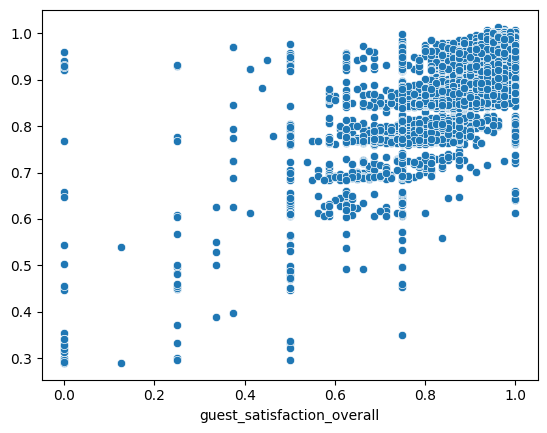

In [29]:
sns.scatterplot(x=y_test, y=y_pred_test);

### Decision Tree

In [30]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
y_pred_test_dt = tree.predict(X_test)

In [31]:
print(f"MAE, {mean_absolute_error(y_pred_test_dt, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_dt, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_dt, y_test): .2f}")
print(f"R2 score, {tree.score(X_test, y_test): .2f}")

MAE,  0.05
MSE,  0.01
RMSE,  0.07
R2 score,  0.57


### Bagging

In [32]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)
bagging_reg.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 max_samples=1000, n_estimators=100)

In [33]:
y_pred_test_bag = bagging_reg.predict(X_test)

print(f"MAE {mean_absolute_error(y_pred_test_bag, y_test): .2f}")
print(f"MSE {mean_squared_error(y_pred_test_bag, y_test): .2f}")
print(f"RMSE {root_mean_squared_error(y_pred_test_bag, y_test): .2f}")
print(f"R2 score {bagging_reg.score(X_test, y_test): .2f}")

MAE  0.05
MSE  0.01
RMSE  0.07
R2 score  0.56


### Random Forest

In [34]:
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [35]:
y_pred_test_rf = forest.predict(X_test)

print(f"MAE, {mean_absolute_error(y_pred_test_rf, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_rf, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_rf, y_test): .2f}")
print(f"R2 score, {forest.score(X_test, y_test): .2f}")

MAE,  0.04
MSE,  0.00
RMSE,  0.06
R2 score,  0.73


### Ada Boosting

In [52]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=100)

In [53]:
y_pred_test_ada = ada_reg.predict(X_test)

#joblib.dump(ada_reg, "../models/satisfaction_model.pkl")

print(f"MAE, {mean_absolute_error(y_pred_test_ada, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_ada, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_ada, y_test): .2f}")
print(f"R2 score, {ada_reg.score(X_test, y_test): .2f}")

MAE,  0.03
MSE,  0.00
RMSE,  0.05
R2 score,  0.80


In [38]:
# Hypermarameter Tuning (Grid Search)
ada = ada_reg

param_grid = {
    "n_estimators": [50,100],  
    "learning_rate": [0.1, 1.0],  
    "loss": ["linear"]  
}

folds = 10
gs = GridSearchCV(ada, param_grid=param_grid, cv=folds, verbose=5, scoring="r2", n_jobs = -1)

start_time = time.time()
gs.fit(X_train, y_train)
end_time = time.time()

print("\n")
print(f"Tiempo en encontrar la mejor combinación de hiperparámetros: {end_time - start_time:.4f} segundos")
print(f"Mejores hiperparámetros: {gs.best_params_}")
print(f"Mejor R² en validación cruzada: {gs.best_score_:.4f}")

best_model = gs.best_estimator_
y_pred_test = best_model.predict(X_test)

print("\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"R² Score (Test): {r2_score(y_test, y_pred_test):.2f}")
print("\n")

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Tiempo en encontrar la mejor combinación de hiperparámetros: 146.4229 segundos
Mejores hiperparámetros: {'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}
Mejor R² en validación cruzada: 0.7641


MAE: 0.03
MSE: 0.00
RMSE: 0.05
R² Score (Test): 0.80


[CV 7/10] END learning_rate=0.1, loss=linear, n_estimators=50;, score=0.701 total time=  16.6s
[CV 5/10] END learning_rate=0.1, loss=linear, n_estimators=100;, score=0.746 total time=  32.7s
[CV 4/10] END learning_rate=1.0, loss=linear, n_estimators=50;, score=0.753 total time=  14.5s
[CV 6/10] END learning_rate=1.0, loss=linear, n_estimators=50;, score=0.781 total time=  14.9s
[CV 2/10] END learning_rate=1.0, loss=linear, n_estimators=100;, score=0.781 total time=  28.6s
[CV 4/10] END learning_rate=0.1, loss=linear, n_estimators=50;, score=0.737 total time=  16.4s
[CV 2/10] END learning_rate=0.1, loss=linear, n_estimators=100;, score=0.771 total time=  32.3s
[CV 1/1

In [39]:
# Hypermarameter Tuning (Random Search)
ada = ada_reg

param_grid = {
    "n_estimators": [50, 100],  
    "learning_rate": [0.1, 1.0],  
    "loss": ["linear"]
}

folds = 10
n_iter = 4  

rs = RandomizedSearchCV(ada, param_distributions=param_grid, n_iter=n_iter, cv=folds, 
                        verbose=10, scoring="r2", n_jobs=-1, random_state=123)

start_time = time.time()
rs.fit(X_train, y_train)
end_time = time.time()

print("\n")
print(f"Tiempo en encontrar la mejor combinación de hiperparámetros: {end_time - start_time:.4f} segundos")
print(f"Mejores hiperparámetros: {rs.best_params_}")
print(f"Mejor R² en validación cruzada: {rs.best_score_:.4f}")

results_rs_df = pd.DataFrame(rs.cv_results_).sort_values(by="mean_test_score", ascending=False)

rs_mean_score = results_rs_df.iloc[0, -3]
rs_sem = results_rs_df.iloc[0, -2] / np.sqrt(folds)

confidence_level = 0.95
rs_tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
rs_lower_bound = rs_mean_score - (rs_tc * rs_sem)
rs_upper_bound = rs_mean_score + (rs_tc * rs_sem)

print(f"El intervalo de confianza para el mejor R² es: ({rs_lower_bound:.4f}, {rs_mean_score:.4f}, {rs_upper_bound:.4f})")

best_model = rs.best_estimator_

y_pred_test = best_model.predict(X_test)

print("\n")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"R² Score (Test): {r2_score(y_test, y_pred_test):.2f}")
print("\n")

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Tiempo en encontrar la mejor combinación de hiperparámetros: 146.4090 segundos
Mejores hiperparámetros: {'n_estimators': 100, 'loss': 'linear', 'learning_rate': 1.0}
Mejor R² en validación cruzada: 0.7648
El intervalo de confianza para el mejor R² es: (0.7545, 0.7648, 0.7751)


MAE: 0.03
MSE: 0.00
RMSE: 0.05
R² Score (Test): 0.79




### Gradient Boosting

In [40]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=20)

In [41]:
y_pred_test_gb = gb_reg.predict(X_test)

print(f"MAE, {mean_absolute_error(y_pred_test_gb, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_gb, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_gb, y_test): .2f}")
print(f"R2 score, {gb_reg.score(X_test, y_test): .2f}")

MAE,  0.03
MSE,  0.00
RMSE,  0.05
R2 score,  0.76
[CV 2/10; 1/4] START learning_rate=0.1, loss=linear, n_estimators=50............
[CV 2/10; 1/4] END learning_rate=0.1, loss=linear, n_estimators=50;, score=0.755 total time=  15.9s
[CV 9/10; 1/4] START learning_rate=0.1, loss=linear, n_estimators=50............
[CV 9/10; 1/4] END learning_rate=0.1, loss=linear, n_estimators=50;, score=0.725 total time=  15.6s
[CV 7/10; 2/4] START learning_rate=0.1, loss=linear, n_estimators=100...........
[CV 7/10; 2/4] END learning_rate=0.1, loss=linear, n_estimators=100;, score=0.718 total time=  32.5s
[CV 8/10; 3/4] START learning_rate=1.0, loss=linear, n_estimators=50............
[CV 8/10; 3/4] END learning_rate=1.0, loss=linear, n_estimators=50;, score=0.757 total time=  14.6s
[CV 3/10; 4/4] START learning_rate=1.0, loss=linear, n_estimators=100...........
[CV 3/10; 4/4] END learning_rate=1.0, loss=linear, n_estimators=100;, score=0.788 total time=  29.2s
[CV 6/10; 1/4] START learning_rate=0.1, los

In [48]:
def objective(trial, confidence_level, folds):
    # Definir el grid de hiperparámetros para la búsqueda bayesiana
    n_estimators = trial.suggest_int("n_estimators", 50, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 1.0)
    loss = trial.suggest_categorical("loss", ["linear", "square", "exponential"])

    # Crear el modelo de AdaBoostRegressor
    ada = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, loss=loss, random_state=123)

    # Evaluación con validación cruzada
    scores = cross_val_score(ada, X_train, y_train, cv=folds, scoring="r2")
    mean_score = np.mean(scores)
    sem = np.std(scores, ddof=1) / np.sqrt(folds)

    tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
    lower_bound = mean_score - (tc * sem)
    upper_bound = mean_score + (tc * sem)

    # Guardar información adicional en Optuna
    trial.set_user_attr("CV_score_summary", [round(lower_bound, 4), round(mean_score, 4), round(upper_bound, 4)])

    return mean_score